In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

In [43]:
#Clase que detendra el sobre ajuste
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')
def print_history(history):  
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Graficación de la pérdida durante el entrenamiento y la validación
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Graficación de la precisión durante el entrenamiento y la validación
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Tratamiento de la data, en este caso se construiran 3 diferentes modelos para cual trabajaremos de 3 diferentes formas con la data
* 1 Se hara uso de one hot encoding
* 2 Se le asignara un valor numerico para cada variable categorica
* 3 Se normalizara la data del punto 2

In [2]:
data = pd.read_csv("training-ds.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964 entries, 0 to 963
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Tipo de Red               964 non-null    object
 1   Estudiante de Tecnología  964 non-null    object
 2   Nivel de Educación        964 non-null    object
 3   Vive en Ciudad            964 non-null    object
 4   Tipo de Instituto         964 non-null    object
 5   Edad                      964 non-null    object
 6   Dispositivo               964 non-null    object
 7   Tipo de Internet          964 non-null    object
 8   Situación Financiera      964 non-null    object
 9   Género                    964 non-null    object
 10  Duración de la Clase      964 non-null    object
 11  Nivel de Adaptación       964 non-null    object
dtypes: object(12)
memory usage: 90.5+ KB
None


In [3]:
data.shape

(964, 12)

Manejo de la data que no esta en el formato deseado

In [91]:
def convertir_mes_a_numero(fecha):
    if len(fecha) == 5 and fecha[1] == '-' and fecha[2:].isdigit():
        return fecha  
    
    meses = {
        'Jan': '1', 'Feb': '2', 'Mar': '3', 'Apr': '4',
        'May': '5', 'Jun': '6', 'Jul': '7', 'Aug': '8',
        'Sep': '9', 'Oct': '10', 'Nov': '11', 'Dec': '12'
    }
    if len(fecha) == 6 and fecha[2] == '-' and fecha[:2].isdigit():
        numero_mes = meses.get(fecha[3:])
        if numero_mes:
            return f"{int(fecha[:2])}-{numero_mes.zfill(2)}"
    
    partes = fecha.split('-')
    numero_mes = meses.get(partes[0])
    if numero_mes:
        return f"{numero_mes}-{partes[1]}"
    else:
        return fecha 

data['Edad'] = data['Edad'].apply(convertir_mes_a_numero)
data['Duración de la Clase'] = data['Duración de la Clase'].apply(convertir_mes_a_numero)

In [92]:
data

,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,3G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Media,Masculino,3-06,0
1,3G,No,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Femenino,1-03,1
2,3G,Si,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Mala,Masculino,1-03,0
3,3G,Si,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Masculino,1-03,1
4,4G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Buena,Masculino,1-03,2
...,...,...,...,...,...,...,...,...,...,...,...,...
959,3G,No,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Media,Masculino,1-03,1
960,3G,No,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Femenino,1-03,1
961,4G,No,Universidad,Si,Público,21-25,Smartphone,Compra Megas,Media,Masculino,0,0
962,3G,No,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Media,Masculino,1-03,1


In [6]:
display(data.dtypes)

Tipo de Red                 object
Estudiante de Tecnología    object
Nivel de Educación          object
Vive en Ciudad              object
Tipo de Instituto           object
Edad                        object
Dispositivo                 object
Tipo de Internet            object
Situación Financiera        object
Género                      object
Duración de la Clase        object
Nivel de Adaptación         object
dtype: object

In [7]:
def print_unique_values(data_frame, dtype='object'):
    for column in data_frame.columns:
        if data_frame[column].dtype == dtype:
            print(f'{column}: {list(data_frame[column].unique())}')


print_unique_values(data)

Tipo de Red: ['3G', '4G', '2G']
Estudiante de Tecnología: ['Si', 'No']
Nivel de Educación: ['Universidad', 'Escuela', 'Colegio']
Vive en Ciudad: ['Si', 'No']
Tipo de Instituto: ['Privado', 'Público']
Edad: ['21-25', '11-15', '16-20', '26-30', '1-05', '6-10']
Dispositivo: ['Computadora', 'Smartphone', 'Tableta']
Tipo de Internet: ['Wifi', 'Compra Megas']
Situación Financiera: ['Media', 'Mala', 'Buena']
Género: ['Masculino', 'Femenino']
Duración de la Clase: ['3-06', '1-03', '0']
Nivel de Adaptación: ['Bajo', 'Moderado', 'Alto']


Manejo de la data tipo 1

In [8]:
data_transform= data
data_transform = pd.get_dummies(data, columns=[ 'Estudiante de Tecnología', "Vive en Ciudad",'Tipo de Instituto','Tipo de Internet','Género'])
display(data_transform.head(100))

,Tipo de Red,Nivel de Educación,Edad,Dispositivo,Situación Financiera,Duración de la Clase,Nivel de Adaptación,Estudiante de Tecnología_No,Estudiante de Tecnología_Si,Vive en Ciudad_No,Vive en Ciudad_Si,Tipo de Instituto_Privado,Tipo de Instituto_Público,Tipo de Internet_Compra Megas,Tipo de Internet_Wifi,Género_Femenino,Género_Masculino
0,3G,Universidad,21-25,Computadora,Media,3-06,Bajo,0,1,0,1,1,0,0,1,0,1
1,3G,Escuela,11-15,Smartphone,Media,1-03,Moderado,1,0,0,1,1,0,1,0,1,0
2,3G,Universidad,21-25,Smartphone,Mala,1-03,Bajo,0,1,0,1,1,0,1,0,0,1
3,3G,Escuela,11-15,Smartphone,Media,1-03,Moderado,0,1,0,1,1,0,1,0,0,1
4,4G,Universidad,21-25,Computadora,Buena,1-03,Alto,0,1,0,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4G,Colegio,16-20,Smartphone,Media,0,Bajo,0,1,1,0,0,1,1,0,0,1
96,4G,Escuela,16-20,Computadora,Media,1-03,Bajo,1,0,0,1,1,0,0,1,1,0
97,4G,Universidad,21-25,Smartphone,Media,0,Bajo,1,0,0,1,1,0,1,0,0,1
98,3G,Universidad,21-25,Smartphone,Media,1-03,Bajo,1,0,0,1,0,1,1,0,0,1


### Manejo de la data tipo 2

In [9]:
data_encoded = data.apply(LabelEncoder().fit_transform)
display(data_encoded.head(100))

,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,1,1,2,1,0,3,0,1,2,1,2,1
1,1,0,1,1,0,1,1,0,2,0,1,2
2,1,1,2,1,0,3,1,0,1,1,1,1
3,1,1,1,1,0,1,1,0,2,1,1,2
4,2,1,2,1,0,3,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2,1,0,0,1,2,1,0,2,1,0,1
96,2,0,1,1,0,2,0,1,2,0,1,1
97,2,0,2,1,0,3,1,0,2,1,0,1
98,1,0,2,1,1,3,1,0,2,1,1,1


### Data tipo 3

In [59]:
scaler = StandardScaler()
labels = data_encoded['Nivel de Adaptación']

# Normalizar las características excepto 'Nivel de Adaptación'
data_except_labels = data_encoded.drop('Nivel de Adaptación', axis=1)
data_except_labels_normalized = scaler.fit_transform(data_except_labels)
data_except_labels_normalized = pd.DataFrame(data_except_labels_normalized, columns=data_except_labels.columns)

# Reconstruir el dataset con las características normalizadas y la columna 'Nivel de Adaptación'
data_normalice = pd.concat([data_except_labels_normalized, labels], axis=1)

display(data_normalice.head(100))

,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,-1.240771,1.722521,1.103632,0.524531,-0.675421,0.735289,-2.228075,1.155050,0.558508,0.901127,1.767815,1
1,-1.240771,-0.580544,-0.278058,0.524531,-0.675421,-0.920829,0.310772,-0.865763,0.558508,-1.109721,-0.080530,2
2,-1.240771,1.722521,1.103632,0.524531,-0.675421,0.735289,0.310772,-0.865763,-1.103225,0.901127,-0.080530,1
3,-1.240771,1.722521,-0.278058,0.524531,-0.675421,-0.920829,0.310772,-0.865763,0.558508,0.901127,-0.080530,2
4,0.710458,1.722521,1.103632,0.524531,-0.675421,0.735289,-2.228075,1.155050,-2.764958,0.901127,-0.080530,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.710458,1.722521,-1.659748,-1.906467,1.480558,-0.092770,0.310772,-0.865763,0.558508,0.901127,-1.928874,1
96,0.710458,-0.580544,-0.278058,0.524531,-0.675421,-0.092770,-2.228075,1.155050,0.558508,-1.109721,-0.080530,1
97,0.710458,-0.580544,1.103632,0.524531,-0.675421,0.735289,0.310772,-0.865763,0.558508,0.901127,-1.928874,1
98,-1.240771,-0.580544,1.103632,0.524531,1.480558,0.735289,0.310772,-0.865763,0.558508,0.901127,-0.080530,1


Buscando que columnas son relevantes  para nuestro modelo en el caso 1

In [14]:
correlation_level_adaption = data_transform.corrwith(data_transform['Nivel de Adaptación'], method='kendall')
# Ordenar por valor absoluto en orden descendente
correlation_level_adaption = correlation_level_adaption.abs().sort_values(ascending=False)
print(correlation_level_adaption.head(11))


Tipo de Instituto_Privado        0.205034
Tipo de Instituto_Público        0.205034
Vive en Ciudad_No                0.136796
Vive en Ciudad_Si                0.136796
Estudiante de Tecnología_No      0.064079
Estudiante de Tecnología_Si      0.064079
Tipo de Internet_Compra Megas    0.049212
Tipo de Internet_Wifi            0.049212
Género_Femenino                  0.024113
Género_Masculino                 0.024113
dtype: float64


C:\Users\miky1\AppData\Local\Temp\ipykernel_15596\1271137229.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_level_adaption = data_transform.corrwith(data_transform['Nivel de Adaptación'], method='kendall')


Buscando que columnas son relevantes  para nuestro modelo en el caso 2

In [17]:
correlation_level_adaption = data_transform.corrwith(data_transform['Nivel de Adaptación'], method='kendall')
# Ordenar por valor absoluto en orden descendente
correlation_level_adaption = correlation_level_adaption.abs().sort_values(ascending=False)
print(correlation_level_adaption.head(11))


Tipo de Instituto_Privado        0.205034
Tipo de Instituto_Público        0.205034
Vive en Ciudad_No                0.136796
Vive en Ciudad_Si                0.136796
Estudiante de Tecnología_No      0.064079
Estudiante de Tecnología_Si      0.064079
Tipo de Internet_Compra Megas    0.049212
Tipo de Internet_Wifi            0.049212
Género_Femenino                  0.024113
Género_Masculino                 0.024113
dtype: float64


C:\Users\miky1\AppData\Local\Temp\ipykernel_15596\1271137229.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_level_adaption = data_transform.corrwith(data_transform['Nivel de Adaptación'], method='kendall')


In [18]:
correlation_nivel_adaptacion_encod = data_encoded.corr(method='pearson')['Nivel de Adaptación']
display((correlation_nivel_adaptacion_encod[np.argsort(correlation_nivel_adaptacion_encod, axis=0)[::-1]]).head(11))

Nivel de Adaptación         1.000000
Situación Financiera        0.258934
Duración de la Clase        0.209937
Vive en Ciudad              0.104525
Dispositivo                 0.066690
Estudiante de Tecnología    0.044715
Tipo de Red                 0.021874
Nivel de Educación         -0.015269
Género                     -0.042976
Tipo de Internet           -0.069489
Tipo de Instituto          -0.172572
Name: Nivel de Adaptación, dtype: float64

Buscando que columnas son relevantes  para nuestro modelo en el caso 3

In [19]:
correlation_nivel_adaptacion_norm = data_normalice.corr(method='pearson')['Nivel de Adaptación']
display((correlation_nivel_adaptacion_norm[np.argsort(correlation_nivel_adaptacion_norm, axis=0)[::-1]]).head(11))

Nivel de Adaptación         1.000000
Situación Financiera        0.258934
Duración de la Clase        0.209937
Vive en Ciudad              0.104525
Dispositivo                 0.066690
Estudiante de Tecnología    0.044715
Tipo de Red                 0.021874
Nivel de Educación         -0.015269
Género                     -0.042976
Tipo de Internet           -0.069489
Tipo de Instituto          -0.172572
Name: Nivel de Adaptación, dtype: float64

# EMpezar a redactar que hiciste wacho Aca empiezan los modelos
 

In [20]:
# Mapear los valores de la columna 'Nivel de Adaptación' a números
mapping = {'Bajo': 0, 'Moderado': 1, 'Alto': 2}
data['Nivel de Adaptación'] = data['Nivel de Adaptación'].map(mapping)

# Verificar el resultado
print(data['Nivel de Adaptación'])


0      0
1      1
2      0
3      1
4      2
      ..
959    1
960    1
961    0
962    1
963    1
Name: Nivel de Adaptación, Length: 964, dtype: int64


In [21]:
x = data.drop('Nivel de Adaptación' , axis = 1)
y = data['Nivel de Adaptación']

In [22]:

x_train , x_test , y_train , y_test = train_test_split(pd.get_dummies(x) , y , test_size = 0.2 , random_state = 42)


In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1:]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100 , activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100 , activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3 , activation = 'softmax')
])

model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy , optimizer = tf.keras.optimizers.Adam() , metrics = ['accuracy'])

model.fit(x_train , y_train , epochs = 100)

Epoch 1/100
25/25 [==============================] - 1s 5ms/step - loss: 1.0459 - accuracy: 0.5447
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6683 - accuracy: 0.7588
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.5685 - accuracy: 0.7782
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 0.5086 - accuracy: 0.7990
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.4744 - accuracy: 0.8275
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 0.4667 - accuracy: 0.8236
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 0.4189 - accuracy: 0.8366
Epoch 8/100
25/25 [==============================] - 0s 4ms/step - loss: 0.4247 - accuracy: 0.8249
Epoch 9/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3833 - accuracy: 0.8612
Epoch 10/100
25/25 [==============================] - 0s 5ms/step - loss: 0.4098 - accuracy: 0.8495
Epoch 11/

In [24]:
loss , acc = model.evaluate(x_test , y_test)
acc

7/7 [==============================] - 0s 5ms/step - loss: 0.3231 - accuracy: 0.8290


0.8290155529975891

### Construccion del modelo para el caso 2

In [44]:

X_encod = data_encoded.drop('Nivel de Adaptación' , axis = 1)
y_encod = data_encoded['Nivel de Adaptación']
x_train_encod , x_test_encod , y_train_encod , y_test_encod = train_test_split(X_encod , y_encod , test_size = 0.2 , random_state = 42)
model_encode = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train_encod.shape[1:]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(33 , activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(66 , activation = "gelu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2) ,
    tf.keras.layers.Dense(3 , activation = 'softmax')
])

# Compilar el modelo
model_encode.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# Entrenar el modelo con callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_encode.fit(x_train_encod, y_train_encod, epochs=100, validation_split=0.2, batch_size=64, callbacks=[early_stop, PrintDot()])


test_loss, test_accuracy = model_encode.evaluate(x_test_encod, y_test_encod)
print(f'Test accuracy: {test_accuracy}')



Epoch 1/100
10/10 [==============================] - 2s 28ms/step - loss: 1.6321 - accuracy: 0.3377 - val_loss: 1.1265 - val_accuracy: 0.3226
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 1.2004 - accuracy: 0.4724 - val_loss: 1.0705 - val_accuracy: 0.5355
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 0.9955 - accuracy: 0.5747 - val_loss: 1.0296 - val_accuracy: 0.5419
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 0.9645 - accuracy: 0.6023 - val_loss: 0.9981 - val_accuracy: 0.5419
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 0.8711 - accuracy: 0.6071 - val_loss: 0.9785 - val_accuracy: 0.5419
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 0.7867 - accuracy: 0.6380 - val_loss: 0.9599 - val_accuracy: 0.5419
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 0.8122 - accuracy: 0.6575 - val_loss: 0.9428 - val_accuracy: 0.5484
Epoch 8/100


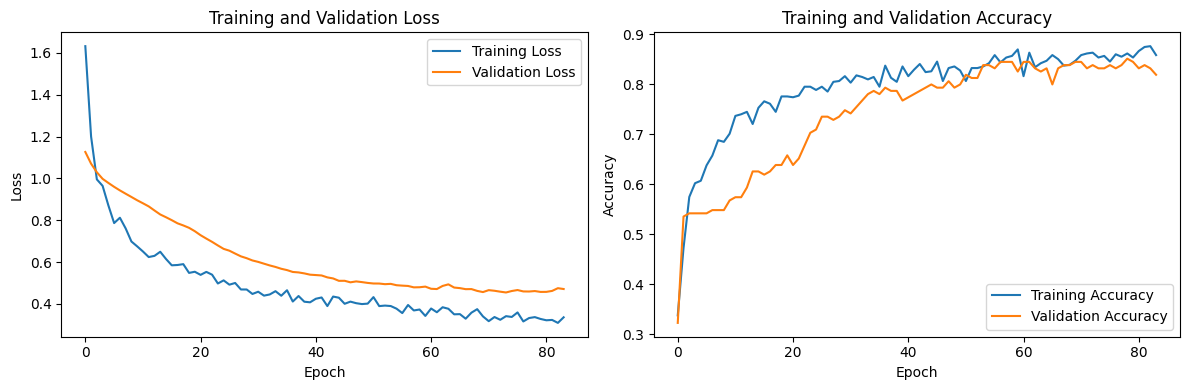

In [45]:

print_history(history)

In [46]:
loss_encod , acc_encod = model_encode.evaluate(x_test_encod , y_test_encod)
acc_encod

7/7 [==============================] - 0s 2ms/step - loss: 0.4030 - accuracy: 0.8238


0.8238341808319092

In [27]:
#guardando el mejor modelo obtenido hasta ahora
#model_dir = './BestModel'
#tf.saved_model.save(model_encode, model_dir)
#model_encode.save('bestAcury86_11_25.h5')

In [28]:
loaded_model = tf.keras.models.load_model('bestAcury86_11_25.h5')

# Ahora puedes utilizar métodos como evaluate y predict en el modelo cargado
loss_encod, acc_encod = loaded_model.evaluate(x_test_encod, y_test_encod)

7/7 [==============================] - 0s 3ms/step - loss: 0.3944 - accuracy: 0.8601


### Caso 3

In [111]:
X_norm = data_normalice.drop('Nivel de Adaptación' , axis = 1)
y_norm = data_normalice['Nivel de Adaptación']
x_train_norm , x_test_norm , y_train_norm , y_test_norm = train_test_split(X_norm , y_norm , test_size = 0.2, random_state = 32 )

model_norm = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=x_train_norm.shape[1:]),
    tf.keras.layers.Dense(33, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_norm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history_norm = model_norm.fit(
    x_train_norm,
    y_train_norm,
    epochs=100,
    validation_split=0.2,
    batch_size=64,
    callbacks=[callback]
)




Epoch 1/100
10/10 [==============================] - 1s 22ms/step - loss: 1.0499 - accuracy: 0.4740 - val_loss: 0.8866 - val_accuracy: 0.6710
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 0.9386 - accuracy: 0.5114 - val_loss: 0.7932 - val_accuracy: 0.6839
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 0.9082 - accuracy: 0.5601 - val_loss: 0.7414 - val_accuracy: 0.6968
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 0.8340 - accuracy: 0.6347 - val_loss: 0.7176 - val_accuracy: 0.7161
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 0.8314 - accuracy: 0.6218 - val_loss: 0.6978 - val_accuracy: 0.7226
Epoch 6/100
10/10 [==============================] - 0s 8ms/step - loss: 0.8026 - accuracy: 0.6445 - val_loss: 0.6841 - val_accuracy: 0.7097
Epoch 7/100
10/10 [==============================] - 0s 8ms/step - loss: 0.7917 - accuracy: 0.6266 - val_loss: 0.6737 - val_accuracy: 0.7355
Epoch 8/100


In [110]:
test_loss_norm, test_accuracy_norm = model_norm.evaluate(x_test_norm, y_test_norm)
print(f'Test accuracy: {test_accuracy_norm}')

7/7 [==============================] - 0s 2ms/step - loss: 0.5678 - accuracy: 0.7409
Test accuracy: 0.7409326434135437


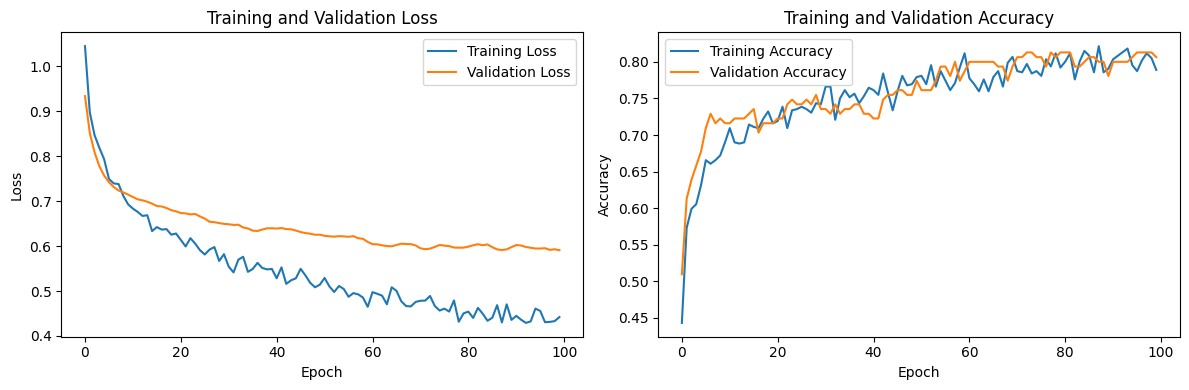

In [86]:
print_history(history_norm)

## CArgando la data con la que realizaremos las prediciones

In [96]:
data_test = pd.read_csv("submission-ds.csv")
data_test
data_test['Edad'] = data_test['Edad'].apply(convertir_mes_a_numero)
data_test['Duración de la Clase'] = data_test['Duración de la Clase'].apply(convertir_mes_a_numero)

data_test1 =pd.get_dummies(data_test)
print_unique_values(data_test)


Tipo de Red: ['3G', '4G', '2G']
Estudiante de Tecnología: ['No', 'Si']
Nivel de Educación: ['Colegio', 'Universidad', 'Escuela']
Vive en Ciudad: ['No', 'Si']
Tipo de Instituto: ['Público', 'Privado']
Edad: ['21-25', '16-20', '6-Oct', '15-11', '1-May', '26-30']
Dispositivo: ['Smartphone', 'Computadora', 'Tableta']
Tipo de Internet: ['Compra Megas', 'Wifi']
Situación Financiera: ['Mala', 'Media', 'Buena']
Género: ['Masculino', 'Femenino']
Duración de la Clase: ['1-Mar', '0', '3-Jun']


In [98]:

data_test = data_test.apply(LabelEncoder().fit_transform)
data_test
data_test3 = data_test
scaler = StandardScaler()
normalized_array = scaler.fit_transform(data_test3)
data_test3 = pd.DataFrame(normalized_array, columns=data_test3.columns)
data_test3


,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase
0,-1.132569,-0.582142,-1.647325,-1.699146,1.418626,0.684911,0.172958,-0.820738,-1.028259,0.916349,-0.107984
1,0.776166,-0.582142,-1.647325,-1.699146,-0.704907,-0.136301,0.172958,1.218415,0.591417,-1.091288,-0.107984
2,0.776166,-0.582142,1.148487,0.588531,1.418626,0.684911,0.172958,-0.820738,0.591417,0.916349,-1.842919
3,-1.132569,1.717795,1.148487,-1.699146,1.418626,0.684911,0.172958,-0.820738,0.591417,0.916349,-0.107984
4,-1.132569,-0.582142,-0.249419,-1.699146,1.418626,2.327333,0.172958,-0.820738,0.591417,-1.091288,-1.842919
...,...,...,...,...,...,...,...,...,...,...,...
236,0.776166,-0.582142,-0.249419,0.588531,-0.704907,-1.778723,0.172958,1.218415,0.591417,-1.091288,-0.107984
237,0.776166,-0.582142,-0.249419,0.588531,-0.704907,-1.778723,0.172958,-0.820738,0.591417,-1.091288,-0.107984
238,0.776166,-0.582142,-0.249419,0.588531,-0.704907,-0.957512,0.172958,-0.820738,0.591417,0.916349,-0.107984
239,0.776166,-0.582142,-0.249419,0.588531,1.418626,-0.136301,0.172958,1.218415,0.591417,0.916349,-0.107984


### Preciendo caso 1

In [113]:
pedict_m1= model.predict(data_test1)
predict_model1 = pedict_m1.argmax(axis=1)
print(predict_model1)

8/8 [==============================] - 0s 2ms/step
[0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0
 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1
 0 1 1 0 1 1 1 1 0 1 1 2 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 2 0 1 1 0 0 1 1 1 1
 0 1 1 0 1 1 1 1 0 1 0 2 0 1 0 1 0 2 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1
 2 1 1 0 1 1 1 1 1 1 1 1 0 2 1 1 0 1 2 1 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 0 0
 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0
 0 0 1 1 1 0 1 1 1 0 2 1 0 0 1 1 1 1 1]


In [169]:
resultados_prediccion1 = pd.DataFrame({
    'id': range(1, len(predict_model1) + 1),
    'Nivel de Adaptación': predict_model1
})
resultados_prediccion1['Nivel de Adaptación'] = resultados_prediccion1['Nivel de Adaptación'].map({0: 'Bajo', 1: 'Moderado', 2: 'Alto'})

print(resultados_prediccion1)
resultados_prediccion1.to_csv('resultados_prediccion_m1.csv', index=False)

      id Nivel de Adaptación
0      1                Bajo
1      2                Bajo
2      3                Bajo
3      4                Bajo
4      5                Bajo
..   ...                 ...
236  237            Moderado
237  238            Moderado
238  239            Moderado
239  240            Moderado
240  241            Moderado

[241 rows x 2 columns]


### Predicion Caso 2

In [112]:
predictions = loaded_model.predict(data_test)
predicted_classes = predictions.argmax(axis=1)
print(predicted_classes)

8/8 [==============================] - 0s 2ms/step
[2 1 1 1 1 0 1 2 1 1 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 1 1 1 2 2 1 0 2 1 1 1
 2 2 1 2 1 1 1 2 2 2 2 1 2 2 1 2 1 2 2 1 2 2 1 2 1 1 2 1 2 1 1 1 2 1 2 1 2
 1 2 2 1 2 2 2 2 1 2 2 0 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 0 1 2 2 1 1 2 2 2 2
 1 2 1 1 2 2 2 0 1 2 1 2 1 2 1 2 1 0 1 2 1 2 2 2 2 1 1 1 2 2 2 2 1 2 2 2 1
 0 2 2 1 2 2 2 2 2 2 2 2 1 0 0 2 1 2 0 2 1 2 2 2 2 1 1 2 1 1 2 1 2 1 2 1 1
 2 1 2 2 2 2 2 1 2 2 1 1 1 1 2 1 1 2 2 2 2 2 1 2 2 1 1 2 2 1 2 2 1 1 1 2 1
 1 1 2 2 2 1 2 2 2 1 0 2 1 1 2 2 2 2 2]


In [105]:
resultados_prediccion = pd.DataFrame({
    'id': range(1, len(predicted_classes) + 1),
    'Nivel de Adaptación': predicted_classes
})
resultados_prediccion['Nivel de Adaptación'] = resultados_prediccion['Nivel de Adaptación'].map({0: 'Alto', 1: 'Bajo', 2: 'Moderado'})

# Mostrar el DataFrame con las etiquetas mapeadas
print(resultados_prediccion)


      id Nivel de Adaptación
0      1            Moderado
1      2                Bajo
2      3                Bajo
3      4                Bajo
4      5                Bajo
..   ...                 ...
236  237            Moderado
237  238            Moderado
238  239            Moderado
239  240            Moderado
240  241            Moderado

[241 rows x 2 columns]


In [108]:
resultados_prediccion.to_csv('resultados_prediccion_ac86.csv', index=False)

### predic model 3

In [99]:
predictions3 = model_norm.predict(data_test3)
predicted_classes3 = predictions3.argmax(axis=1)
print(predicted_classes3)

8/8 [==============================] - 0s 3ms/step
[1 1 1 1 1 2 1 2 2 1 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 1 2 2 2 2 0 2 1 1 1
 0 2 1 2 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2 1 2 2 1 2 1 1 2 1 2 1 1 1 2 1 2 1 2
 1 2 2 1 2 2 2 1 1 2 2 0 1 1 1 2 2 2 2 2 1 2 1 2 2 1 2 2 1 2 2 1 1 2 2 2 2
 1 1 2 2 2 2 2 2 1 2 1 0 1 2 1 2 1 0 1 2 1 2 2 2 2 1 1 1 2 2 2 2 1 2 2 1 2
 0 2 2 1 2 2 2 2 2 2 2 2 1 0 2 2 1 2 0 2 1 2 2 2 2 1 1 2 1 1 2 1 2 2 2 2 1
 2 2 2 1 2 2 2 1 2 2 1 1 1 1 2 1 1 2 2 2 2 2 1 2 2 1 2 2 1 1 2 2 1 2 1 2 1
 1 1 2 2 2 1 2 2 2 1 0 2 1 1 2 2 2 2 2]


In [101]:
resultados_prediccion3 = pd.DataFrame({
    'id': range(1, len(predicted_classes3) + 1),
    'Nivel de Adaptación': predicted_classes3
})
resultados_prediccion3['Nivel de Adaptación'] = resultados_prediccion3['Nivel de Adaptación'].map({0: 'Alto', 1: 'Bajo', 2: 'Moderado'})

# Mostrar el DataFrame con las etiquetas mapeadas
print(resultados_prediccion3)


      id Nivel de Adaptación
0      1                Bajo
1      2                Bajo
2      3                Bajo
3      4                Bajo
4      5                Bajo
..   ...                 ...
236  237            Moderado
237  238            Moderado
238  239            Moderado
239  240            Moderado
240  241            Moderado

[241 rows x 2 columns]


In [113]:
resultados_prediccion3.to_csv('resultados_prediccion_norm.csv', index=False)